In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import libraries

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.svm import SVC, LinearSVC
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

In [3]:
from utils import load_dataset

# Load dataset

In [4]:
def calculate_cdf(series, num_points=1024):
    sorted_series = np.sort(series)
    cdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    sampled_points = np.linspace(np.min(sorted_series), np.max(sorted_series), num_points)
    sampled_cdf = np.interp(sampled_points, sorted_series, cdf)
    return sampled_cdf

In [5]:
def empirical_cdf(series):
    sorted_series = np.sort(series)
    cdf_values = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    return cdf_values

In [6]:
def load_files(files, labels, max_len=None):
    data_arr = []
    final_labels = []
    
    for filepath, label in zip(files, labels):
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        cdf = calculate_cdf(x)

        data_arr.append(cdf)
        final_labels.append(label)
    
    return np.array(data_arr), np.array(final_labels)

In [7]:
def get_train_test_data(data_files):
    train_files = []
    test_files = []

    train_labels = []
    test_labels = []

    for operator in data_files:
        train_files.extend(data_files[operator]['train_files'])
        train_labels.extend([data_files[operator]['label']]*len(data_files[operator]['train_files']))

        test_files.extend(data_files[operator]['test_files'])
        test_labels.extend([data_files[operator]['label']]*len(data_files[operator]['test_files']))

    train_set, train_labels = load_files(train_files, train_labels)
    test_set, test_labels = load_files(test_files, test_labels)

    return train_set, train_labels, test_set, test_labels

In [8]:
secure_sgx_dataset = load_dataset.load_secure_sgx_data(train_size=0.5)

In [9]:
secure_sgx_train_set, secure_sgx_train_labels, secure_sgx_test_set, secure_sgx_test_labels = get_train_test_data(secure_sgx_dataset)
print(f"Secure SGX Train Set Shape: {secure_sgx_train_set.shape}")
print(f"Secure SGX Test Set Shape: {secure_sgx_test_set.shape}")

Secure SGX Train Set Shape: (607, 1024)
Secure SGX Test Set Shape: (608, 1024)


In [10]:
nexmark_dataset = load_dataset.load_nexmark_data(val_size=None)

In [23]:
nexmark_train_set, nexmark_train_labels, nexmark_test_set, nexmark_test_labels = get_train_test_data(nexmark_dataset)

File ../nexmark_dataset/q2_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli.csv is empty.
File ../nexmark_dataset/q6_filter/tail_0_292_filter_bidder_is_not_divisible_by_sum_of_field_moduli+292_filter_category_times_id_plus_seller_mod_duration_is_less_than_initialBid.csv is empty.


# Useful functions

In [11]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print("Training Classification Report:")
    print(classification_report(y_train, train_preds, digits=4))
    print("Test Classification Report:")
    print(classification_report(y_test, test_preds, digits=4))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_preds))

    # ROC Curve
    y_score = model.predict_proba(X_test)
    plt.figure()

    # Confusion Matrix
    print("Confusion Matrix (Test):")
    cm = confusion_matrix(y_test, test_preds)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=load_dataset.NEXMARK_CLASS_NAMES, 
                yticklabels=load_dataset.NEXMARK_CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.figure()
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_test], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{load_dataset.NEXMARK_CLASS_NAMES[i]} (area = {roc_auc_score([1 if y == i else 0 for y in y_test], y_score[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [12]:
def evaluate(model, X_train, y_train, X_test, y_test, class_names):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    print("Training Classification Report:")
    print(classification_report(y_train, train_preds, digits=4))
    print("Test Classification Report:")
    print(classification_report(y_test, test_preds, digits=4))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_preds))

    # ROC Curve
    y_score = model.predict_proba(X_test)
    plt.figure()

    # Confusion Matrix
    print("Confusion Matrix (Test):")
    cm = confusion_matrix(y_test, test_preds)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    plt.figure()
    for i in range(len(np.unique(y_test))):
        fpr, tpr, _ = roc_curve([1 if y == i else 0 for y in y_test], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (area = {roc_auc_score([1 if y == i else 0 for y in y_test], y_score[:, i]):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [14]:
import pandas as pd

def show_top_k(results, k=5, save=True, save_filename="results.csv"):
    # Number of top results to show
    k = 5  # change this as needed

    # Extract cv_results_ as DataFrame
    results_df = pd.DataFrame(results)

    # Save to CSV
    if save and save_filename is not None:
        results_df.to_csv(save_filename, index=False)

    # Choose the metric to sort by (e.g., mean_test_accuracy, mean_test_f1)
    sort_by = 'mean_test_accuracy'

    # Sort and select top-k
    top_k = results_df.sort_values(by=sort_by, ascending=False).head(k)

    # Columns to print: performance + params
    columns_to_show = [
        sort_by, 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'params'
    ]

    # Print nicely
    print(f"Top {k} models sorted by {sort_by}:")
    print(top_k[columns_to_show].to_string(index=False))


In [15]:
import joblib

def rf_grid_search(x_train, y_train, x_test, y_test, class_names, save_obj, save_filename):
    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [None, 10, 20],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, scoring=scoring, refit='f1')
    rf_grid.fit(x_train, y_train)
    print("Best params: ", rf_grid.best_params_)
    print (f'Train Accuracy - : {rf_grid.score(x_train, y_train):.3f}')
    print (f'Test Accuracy - : {rf_grid.score(x_train, y_train):.3f}')

    evaluate(rf_grid, x_train, y_train, x_test, y_test, class_names)
    joblib.dump(rf_grid, save_obj)
    show_top_k(rf_grid.cv_results_, save_filename=save_filename)

    return rf_grid

In [16]:
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def svr_grid_search(x_train, y_train, x_test, y_test, class_names, save_obj, save_filename):
    # Define pipeline: scaler + SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC())
    ])

    # Hyperparameter grid
    param_grid = {
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'svc__kernel': ['linear', 'rbf', 'poly']
    }

    # Grid search with pipeline
    svr_grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        refit='f1'
    )

    svr_grid.fit(x_train, y_train)
    # svr_grid.fit(x_train, y_train)
    print("Best params: ", svr_grid.best_params_)
    print (f'Train Accuracy - : {svr_grid.score(x_train, y_train):.3f}')
    print (f'Test Accuracy - : {svr_grid.score(x_train, y_train):.3f}')

    joblib.dump(svr_grid, save_obj)
    show_top_k(svr_grid.cv_results_, save_filename=save_filename)
    
    evaluate(svr_grid, x_train, y_train, x_test, y_test, class_names)

    return svr_grid

In [17]:
import joblib
from xgboost import XGBClassifier

def xgb_grid_search(x_train, y_train, x_test, y_test, class_names, save_obj, save_filename):
    param_grid = {
        'n_estimators': [100, 150, 200, 250, 300],
        'max_depth': [3, 6, 10],
        'gamma': [0, 1, 5]
    }

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)

    xgb_grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=scoring,  # or 'f1', 'roc_auc', etc.
        cv=5,
        n_jobs=-1,
        verbose=2,
        refit='f1'
    )

    xgb_grid.fit(x_train, y_train)
    print("Best params: ", xgb_grid.best_params_)
    print (f'Train Accuracy - : {xgb_grid.score(x_train, y_train):.3f}')
    print (f'Test Accuracy - : {xgb_grid.score(x_train, y_train):.3f}')

    evaluate(xgb_grid, x_train, y_train, x_test, y_test, class_names)
    joblib.dump(xgb_grid, save_obj)
    show_top_k(xgb_grid.cv_results_, save_filename=save_filename)

    return xgb_grid

# Secure SGX Classification

### Random Forest

Training Classification Report:
              precision    recall  f1-score   support

           0     0.9694    1.0000    0.9845       190
           1     1.0000    0.9659    0.9827       176
           2     1.0000    1.0000    1.0000       241

    accuracy                         0.9901       607
   macro avg     0.9898    0.9886    0.9890       607
weighted avg     0.9904    0.9901    0.9901       607

Test Classification Report:
              precision    recall  f1-score   support

           0     0.7489    0.8632    0.8020       190
           1     0.8219    0.6818    0.7453       176
           2     0.9959    1.0000    0.9979       242

    accuracy                         0.8651       608
   macro avg     0.8556    0.8483    0.8484       608
weighted avg     0.8683    0.8651    0.8636       608

Confusion Matrix (Test):
[[164  26   0]
 [ 55 120   1]
 [  0   0 242]]
Confusion Matrix (Test):
[[164  26   0]
 [ 55 120   1]
 [  0   0 242]]


<Figure size 640x480 with 0 Axes>

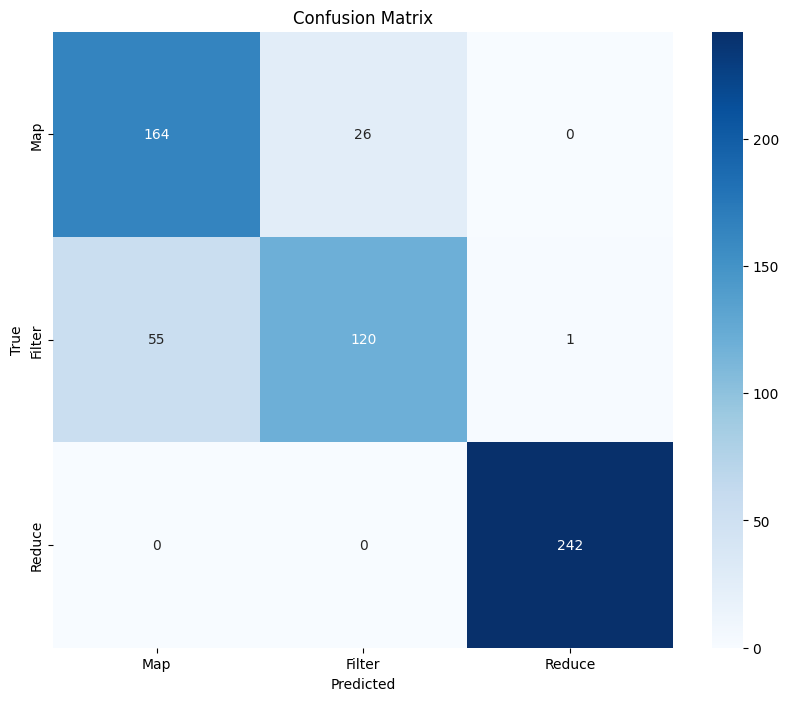

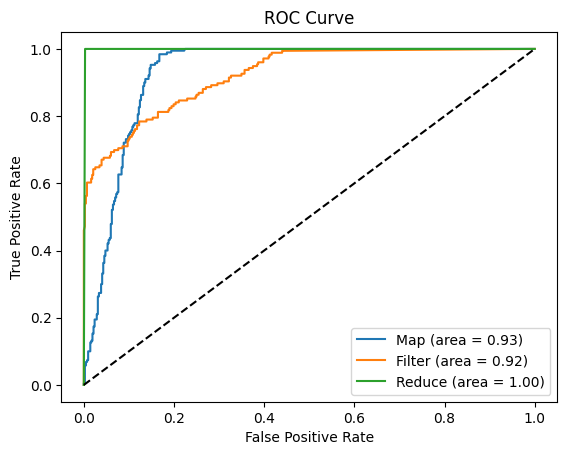

In [ ]:
# secure_sgx_rf_model = rf_grid_search(
#     secure_sgx_train_set, 
#     secure_sgx_train_labels, 
#     secure_sgx_test_set, 
#     secure_sgx_test_labels,
#     load_dataset.SECURE_SGX_CLASS_NAMES,
#     "models/secure_sgx_rf.pkl",
#     "models/secure_sgx_rf.csv"
# )

secure_sgx_rf_model = joblib.load('models/secure_sgx_rf.pkl')
evaluate(secure_sgx_rf_model, secure_sgx_train_set, secure_sgx_train_labels, secure_sgx_test_set, secure_sgx_test_labels, load_dataset.SECURE_SGX_CLASS_NAMES)

### SVM

In [20]:
# secure_sgx_svr_model = svr_grid_search(
#     secure_sgx_train_set, 
#     secure_sgx_train_labels, 
#     secure_sgx_test_set, 
#     secure_sgx_test_labels,
#     load_dataset.SECURE_SGX_CLASS_NAMES,
#     "models/secure_sgx_svr.pkl",
#     "models/secure_sgx_svr.csv"
# )

secure_sgx_svr_model = joblib.load('models/secure_sgx_svr.pkl')
evaluate(secure_sgx_svr_model, secure_sgx_train_set, secure_sgx_train_labels, secure_sgx_test_set, secure_sgx_test_labels, load_dataset.SECURE_SGX_CLASS_NAMES)

Training Classification Report:
              precision    recall  f1-score   support

           0     0.7941    0.9947    0.8832       190
           1     0.9922    0.7216    0.8355       176
           2     1.0000    1.0000    1.0000       241

    accuracy                         0.9176       607
   macro avg     0.9288    0.9054    0.9062       607
weighted avg     0.9333    0.9176    0.9157       607

Test Classification Report:
              precision    recall  f1-score   support

           0     0.7073    0.9158    0.7982       190
           1     0.8583    0.5852    0.6959       176
           2     0.9959    0.9959    0.9959       242

    accuracy                         0.8520       608
   macro avg     0.8538    0.8323    0.8300       608
weighted avg     0.8659    0.8520    0.8473       608

Confusion Matrix (Test):
[[174  16   0]
 [ 72 103   1]
 [  0   1 241]]


AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'

### XGB

Training Classification Report:
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524       190
           1     1.0000    0.8920    0.9429       176
           2     1.0000    1.0000    1.0000       241

    accuracy                         0.9687       607
   macro avg     0.9697    0.9640    0.9651       607
weighted avg     0.9715    0.9687    0.9686       607

Test Classification Report:
              precision    recall  f1-score   support

           0     0.7246    0.9000    0.8028       190
           1     0.8527    0.6250    0.7213       176
           2     0.9959    1.0000    0.9979       242

    accuracy                         0.8602       608
   macro avg     0.8577    0.8417    0.8407       608
weighted avg     0.8697    0.8602    0.8569       608

Confusion Matrix (Test):
[[171  19   0]
 [ 65 110   1]
 [  0   0 242]]
Confusion Matrix (Test):
[[171  19   0]
 [ 65 110   1]
 [  0   0 242]]


<Figure size 640x480 with 0 Axes>

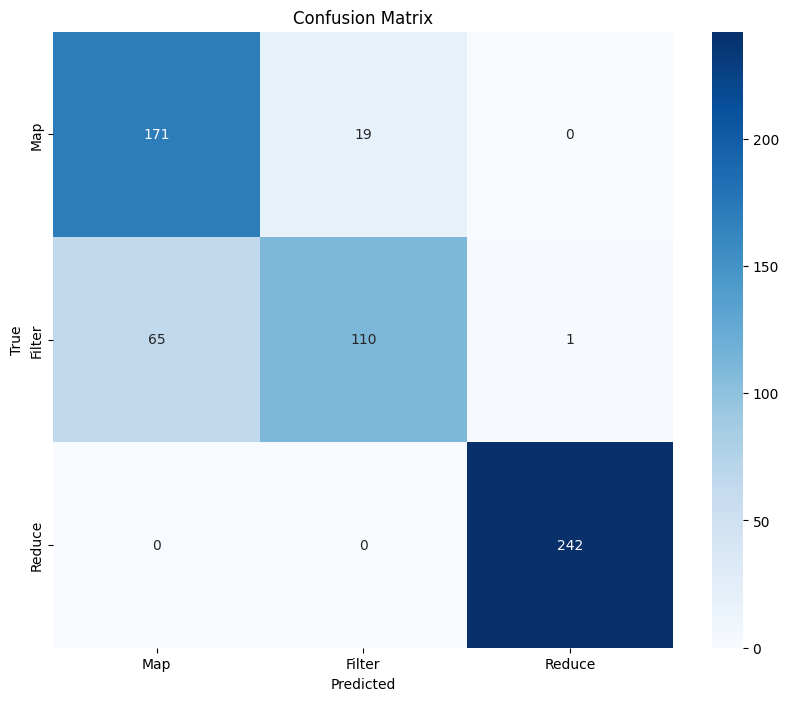

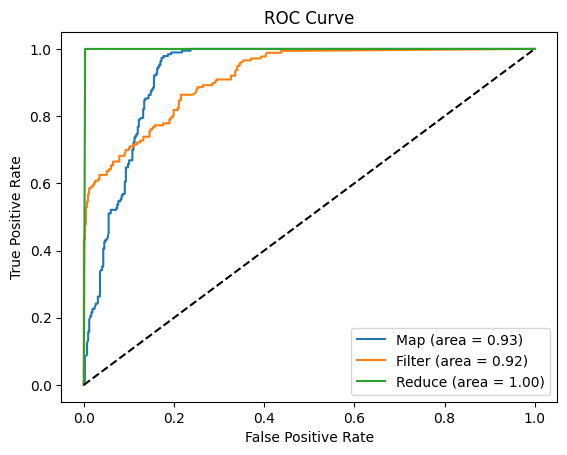

In [22]:
# secure_sgx_xgb_model = xgb_grid_search(
#     secure_sgx_train_set, 
#     secure_sgx_train_labels, 
#     secure_sgx_test_set, 
#     secure_sgx_test_labels,
#     load_dataset.SECURE_SGX_CLASS_NAMES,
#     "models/secure_sgx_xgb.pkl",
#     "models/secure_sgx_xgb.csv"
# )

secure_sgx_xgb_model = joblib.load('models/secure_sgx_xgb.pkl')
evaluate(secure_sgx_xgb_model, secure_sgx_train_set, secure_sgx_train_labels, secure_sgx_test_set, secure_sgx_test_labels, load_dataset.SECURE_SGX_CLASS_NAMES)

# NEXMARK

### Random Forest

Training Classification Report:
              precision    recall  f1-score   support

           0     0.9537    1.0000    0.9763       494
           1     0.9954    0.9644    0.9797       675
           2     0.9960    1.0000    0.9980       504
           3     1.0000    0.9909    0.9954       547
           4     0.9980    1.0000    0.9990       509
           5     1.0000    0.9907    0.9953       535
           6     0.9868    0.9973    0.9920       375

    accuracy                         0.9904      3639
   macro avg     0.9900    0.9919    0.9908      3639
weighted avg     0.9907    0.9904    0.9904      3639

Test Classification Report:
              precision    recall  f1-score   support

           0     0.7298    0.4466    0.5541       768
           1     0.5395    0.7823    0.6386       620
           2     0.9843    0.4970    0.6605       505
           3     0.8393    0.5000    0.6267       512
           4     0.6067    1.0000    0.7552       509
           5     0

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6

<Figure size 640x480 with 0 Axes>

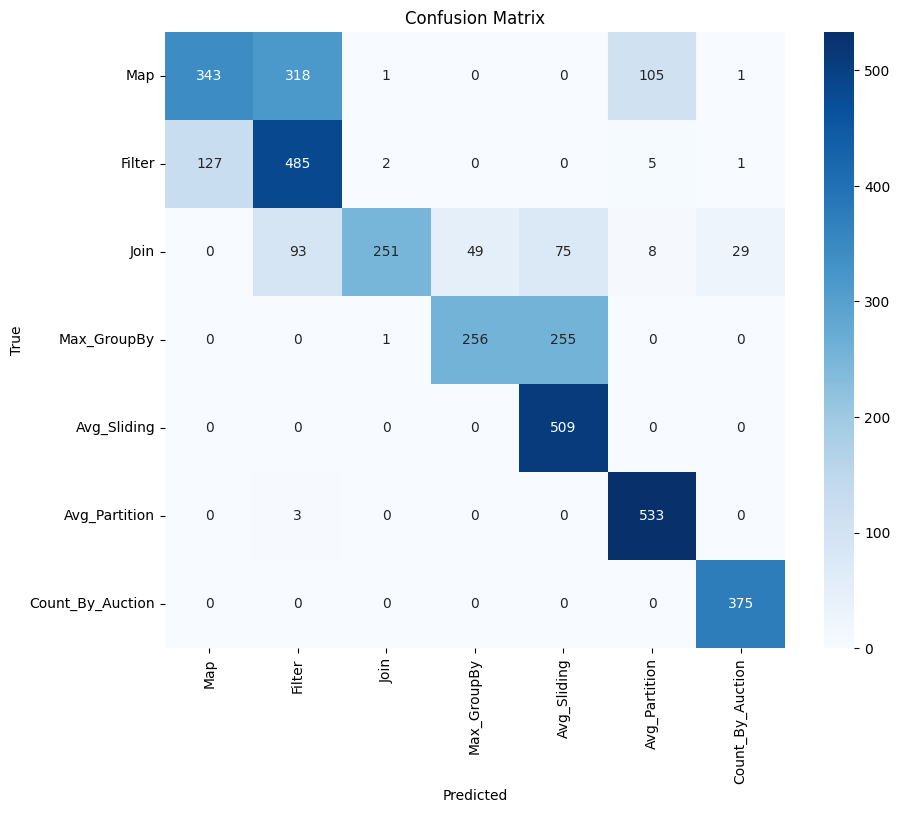

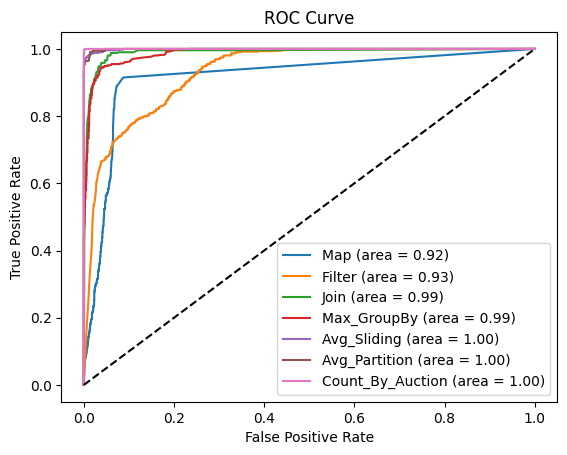

In [24]:
# nexmark_rf_model = rf_grid_search(
#     nexmark_train_set, 
#     nexmark_train_labels, 
#     nexmark_test_set, 
#     nexmark_test_labels,
#     load_dataset.NEXMARK_CLASS_NAMES,
#     "models/nexmark_rf.pkl",
#     "models/nexmark_rf.csv"
# )

nexmark_rf_model = joblib.load('models/nexmark_rf.pkl')
evaluate(nexmark_rf_model, nexmark_train_set, nexmark_train_labels, nexmark_test_set, nexmark_test_labels, load_dataset.NEXMARK_CLASS_NAMES)

### XGB

Training Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       494
           1     1.0000    1.0000    1.0000       675
           2     0.9980    1.0000    0.9990       504
           3     1.0000    0.9982    0.9991       547
           4     0.9980    1.0000    0.9990       509
           5     1.0000    0.9981    0.9991       535
           6     1.0000    1.0000    1.0000       375

    accuracy                         0.9995      3639
   macro avg     0.9994    0.9995    0.9995      3639
weighted avg     0.9995    0.9995    0.9995      3639

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9091    0.0391    0.0749       768
           1     0.3676    0.9516    0.5303       620
           2     0.0000    0.0000    0.0000       505
           3     0.8655    0.9805    0.9194       512
           4     0.8478    0.9961    0.9160       509
           5     0

/home/bkcs/miniforge3/lib/python3.12/pickle.py:1760: UserWarning: [16:31:25] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 640x480 with 0 Axes>

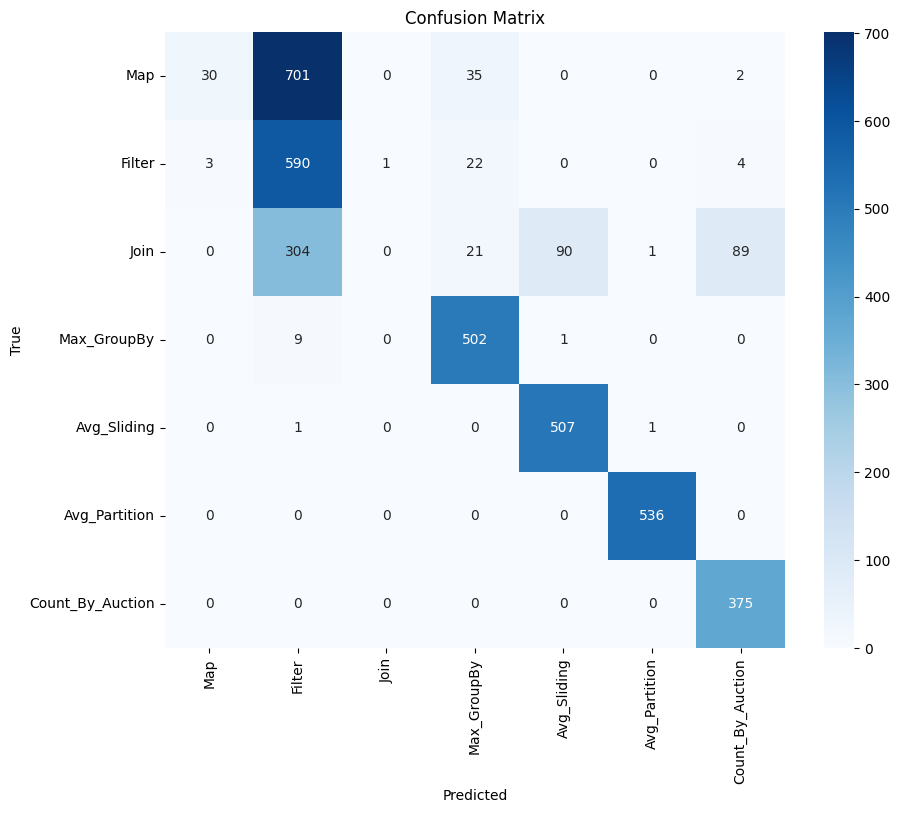

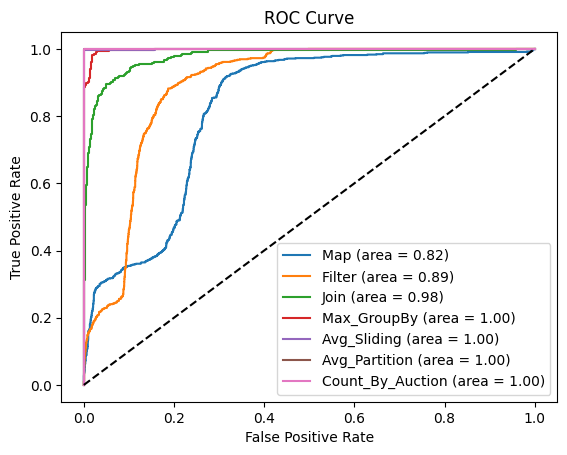

In [25]:
# nexmark_xgb = xgb_grid_search(
#     nexmark_train_set, 
#     nexmark_train_labels, 
#     nexmark_test_set, 
#     nexmark_test_labels,
#     load_dataset.NEXMARK_CLASS_NAMES,
#     "models/nexmark_xgb.pkl",
#     "models/nexmark_xgb.csv"
# )

nexmark_xgb = joblib.load('models/nexmark_xgb.pkl')
evaluate(nexmark_xgb, nexmark_train_set, nexmark_train_labels, nexmark_test_set, nexmark_test_labels, load_dataset.NEXMARK_CLASS_NAMES)

### SVM

In [26]:
# nexmark_svr = svr_grid_search(
#     nexmark_train_set, 
#     nexmark_train_labels, 
#     nexmark_test_set, 
#     nexmark_test_labels,
#     load_dataset.NEXMARK_CLASS_NAMES,
#     "models/nexmark_svr.pkl",
#     "models/nexmark_svr.csv"
# )

nexmark_svr = joblib.load('models/nexmark_svr.pkl')
evaluate(nexmark_svr, nexmark_train_set, nexmark_train_labels, nexmark_test_set, nexmark_test_labels, load_dataset.NEXMARK_CLASS_NAMES)

/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bkcs/HDD/hungpm/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.2. Th

Training Classification Report:
              precision    recall  f1-score   support

           0     0.9368    0.9899    0.9626       494
           1     0.9892    0.9511    0.9698       675
           2     0.9921    1.0000    0.9960       504
           3     1.0000    0.9909    0.9954       547
           4     1.0000    0.9980    0.9990       509
           5     1.0000    0.9963    0.9981       535
           6     0.9867    0.9920    0.9894       375

    accuracy                         0.9865      3639
   macro avg     0.9864    0.9883    0.9872      3639
weighted avg     0.9870    0.9865    0.9866      3639

Test Classification Report:
              precision    recall  f1-score   support

           0     0.8687    0.5169    0.6482       768
           1     0.5659    0.7823    0.6567       620
           2     0.7695    0.4297    0.5515       505
           3     0.9573    0.8750    0.9143       512
           4     0.7320    0.9980    0.8446       509
           5     0

AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'